# Tratamiento de datos, obtención subconjuntos

### Importaciones y funciones

In [1]:
import numpy as np
import pandas as pd
import logging
import os
import json
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

from rdkit.Chem import AllChem as Chem
from rdkit.DataStructs import ConvertToNumpyArray
from rdkit.Chem import Descriptors

from padelpy import padeldescriptor 

from scaffold_splits import scaffold_split 

from utils import * #Adaptado de from https://github.com/chemprop/chemprop/blob/master/chemprop/data/scaffold.py


## Tratamiento de los datos

En primer lugar se comprueba que no haya datos que carezcan de sentido. Para ello se comprueba si existen datos con longitud de onda menores de 170nm o mayores de 1100nm. Se encuentran 4 instancias donde $ \lambda_{max} = 0$ nm , todas ellas corresponden a la misma base de datos orginal. Se eliminan y no se usan en adelante. Existe un valor en el IR que se elimina, no por su $ \lambda_{max}$, si no,  por contener no contener valores numéricos (NaN).

Para poder calcular la distancia, los floats deben normalizarse pues las fingerprints consisten de datos binarios, uso la función StandardScaler. Si no se estandarizasen los datos, parametros como homo, lumo, o energías de transición tendrían demasiado peso frente a las fingerprints.

In [3]:
df= pd.read_csv('uvvis/data_processed/master_df_all_features.csv')
matching_rows = df[(df['peakwavs_max'] < 160) | (df['peakwavs_max'] > 1100)]

print("Matching rows:")
print(matching_rows)

Matching rows:
                                                smiles   solvent  \
21748    Oc1ccccc1CNCc1ccccc1OCCCOc1ccccc1CNCc1ccccc1O  CN(C)C=O   
21782  Oc1ccccc1C=NCc1ccccc1OCCCOc1ccccc1CN=Cc1ccccc1O  CN(C)C=O   
21817                                             P[W]  CN(C)C=O   
23249        CCN(CC)c1ccc2cc(-c3nc4ccccc4s3)c(=O)oc2c1      CC#N   
23849                                        OC1CCCCC1      CC#N   

       peakwavs_max source      homo      lumo  wb97_vert1  wb97_vert2  \
21748           0.0   cdex -7.757884  1.401495       5.017       5.104   
21782           0.0   cdex -7.952908  0.081716       4.345       4.442   
21817        1150.0   cdex       NaN       NaN         NaN         NaN   
23249           0.0   cdex -7.531894 -0.635930       3.542       4.513   
23849           0.0   cdex -9.881434  2.252177       7.410       8.272   

       wb97_vert3  wb97_vert4  ...  alpha  beta  gamma  phi**2  psi**2  \
21748       5.122       5.206  ...   0.00  0.74  49.56   

In [5]:
df = pd.read_csv('master_df_all_features.csv')
df = df.drop([21748, 21782, 23249, 23849]) #elimina valores de peakwavs_max =0 
df = df.dropna()
# Seleccionar solo las columnas de tipo float excluyendo la lambdamax
float_columns = df.select_dtypes(include=['float64']).columns.drop('peakwavs_max', errors='ignore')

# Aplicar el normalizado solo a las columnas de tipo float
scaler = StandardScaler(with_mean = True , with_std = True) 
df[float_columns] = scaler.fit_transform(df[float_columns])


# Guardar el nuevo archivo CSV
output_path = 'scaled_df.csv'
df.to_csv(output_path, index=False)

print(f"Archivo guardado en: {output_path}")

Archivo guardado en: scaled_df.csv


### Histograma count / nm

/home/xavi/Escritorio/midirectorio/utils.py:114: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df = df.groupby(['smiles','solvent']).agg(agg_dict).reset_index()


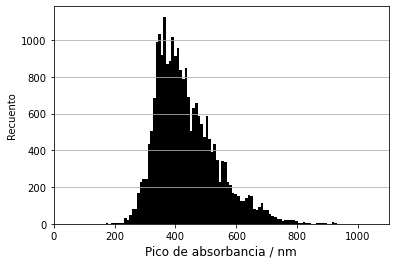

In [27]:
df = pd.read_csv('scaled_df.csv')
no_duplicates_df = handle_duplicates(df, cutoff=5)
df = no_duplicates_df.copy()

no_duplicates_df['peakwavs_max'].hist(bins=100, color = 'k')
plt.xlim(0,1100)
plt.xlabel('Pico de absorbancia / nm', fontsize=12, color='k')
plt.ylabel('Recuento')
plt.grid(which= 'minor', axis = 'y')
plt.grid(False, axis='x')

plot_name = f"figuras/hist_picos.pdf"
plt.savefig(plot_name, dpi=600, bbox_inches='tight')

In [31]:
df = pd.read_csv('scaled_df.csv')
print(df.shape)
print(df['peakwavs_max'].min())
print(df['peakwavs_max'].max())

(25742, 3033)
162.0
1026.0


# División por scaffold en 5 sets para validación cruzada
Como moléculas cuyo esqueleto o andamio sea el mismo seguramente tengan propiedades parecidas, se dividen para que ninguna con el mismo esqueleto esté en grupos distintos. Esto genera una única partición. 

## Obtención de 5 sets de test
**Donde cada uno representa un 20% del total de la base de datos.**

OJO: el quinto set de test corresponde a train_4.csv

In [3]:
scaled_df = pd.read_csv('scaled_df.csv')

target = 'peakwavs_max'
features = [col for col in scaled_df.columns if col not in ['smiles', 'solvent', 'source', target]]

mi_dir = '/home/xavi/Escritorio/midirectorio/'


numerador = 4
particion = 1

while numerador >= 1:
    porcentaje_train = numerador/(numerador+1)
    porcentaje_test = 1 - porcentaje_train

    if particion ==1:
    
        data_split_and_write(scaled_df,
                             sizes = (porcentaje_train, porcentaje_test),
                             feature_names  = features,
                             target_names = ['peakwavs_max'], 
                             solvation = True, 
                             split_type = 'scaffold', 
                             scale_targets = False, 
                             write_files = True, 
                             random_seed = 36)
    else:
        df = pd.read_csv(f'CV/particiones/train_{particion - 1}.csv')
        data_split_and_write(df,
                             sizes = (porcentaje_train, porcentaje_test),
                             feature_names  = features,
                             target_names = ['peakwavs_max'], 
                             solvation = True, 
                             split_type = 'scaffold', 
                             scale_targets = False, 
                             write_files = True, 
                             random_seed = 36)
    
    scaffolds = {}  # Diccionario para almacenar los DataFrames
    
    for archivo in ['train', 'test']:
        feat = pd.read_csv(f'CV/features_{archivo}.csv')
        target = pd.read_csv(f'CV/smiles_target_{archivo}.csv')
    
        scaffolds[archivo] = feat.join(target)
        scaffolds[archivo].to_csv(f'{mi_dir}CV/particiones/{archivo}_{particion}.csv', index=False)
        
        os.remove(f'CV/features_{archivo}.csv')      #### ESTO ELIMINA LOS ARCHIVOS ORGINALES ###
        os.remove(f'CV/smiles_target_{archivo}.csv') #### ESTO ELIMINA LOS ARCHIVOS ORGINALES ###
    print(f'Particion número: {particion} completada.')
    numerador = numerador -1
    particion = particion +1

100%|██████████| 25742/25742 [00:31<00:00, 826.49it/s] 


Particion número: 1 completada.


100%|██████████| 20593/20593 [00:23<00:00, 874.07it/s] 


Particion número: 2 completada.


100%|██████████| 15444/15444 [00:17<00:00, 868.98it/s] 


Particion número: 3 completada.


100%|██████████| 10296/10296 [00:13<00:00, 763.70it/s]


Particion número: 4 completada.


## Obtención de 5 sets train
**Donde cada uno representa el 80% del total de la base de datos.** 

El primer set de train (`train_1.csv`) obtenido por el código se puede usar directamente. El resto se consiguen de manera trivial uniendo los archivos necesarios. Se renombra de manera manual `train_4.csv` a `test_5.csv` antes de ejecutar la célula de abajo. Después de ejecutarla, mover los test y el  `train_1.csv`  a el directorio `CV/`

In [5]:
test_1 = pd.read_csv('CV/particiones/test_1.csv')
test_2 = pd.read_csv('CV/particiones/test_2.csv')
test_3 = pd.read_csv('CV/particiones/test_3.csv')
test_4 = pd.read_csv('CV/particiones/test_4.csv')
test_5 = pd.read_csv('CV/particiones/test_5.csv')

train_2_original = pd.read_csv('CV/particiones/train_2.csv')
train_3_original = pd.read_csv('CV/particiones/train_3.csv')

train_2 = pd.concat([test_1, train_2_original])            #Ver esquema libreta. 

train_3 = pd.concat([test_1, test_2, train_3_original])    #Ver esquema libreta. 

train_4 =pd.concat([test_1, test_2, test_3, test_5])

train_5 =pd.concat([test_1, test_2, test_3, test_4])


train_2.to_csv('CV/all features/train_2.csv', index=False)
train_3.to_csv('CV/all features/train_3.csv', index=False)
train_4.to_csv('CV/all features/train_4.csv', index=False)
train_5.to_csv('CV/all features/train_5.csv', index=False)